In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import joblib
# Load your data
df = pd.read_csv('stock_price_pivot.csv', parse_dates=['Date'], index_col='Date')


In [2]:
import pymysql
import datetime

In [3]:
df = df.asfreq('B')  # 'B' stands for business day frequency

# Check and forward-fill any missing values
df.fillna(method='ffill', inplace=True)

In [4]:
df

,close_AAPL,close_AMZN,close_GOOGL,close_MSFT
Date,,,,
2023-06-12,183.789993,126.570000,123.639999,331.850006
2023-06-13,183.309998,126.660004,123.830002,334.290009
2023-06-14,183.949997,126.419998,123.669998,337.339996
2023-06-15,186.009995,127.110001,125.089996,348.100006
2023-06-16,184.919998,125.489998,123.529999,342.329987
...,...,...,...,...
2024-06-03,194.029999,178.339996,173.169998,413.519989
2024-06-04,194.350006,179.339996,173.789993,416.070007
2024-06-05,195.869995,181.279999,175.410004,424.010010


In [5]:
df.isnull().values.any()

False

In [6]:
#ADF TEST

#ADF TEST IS A CHECK FOR STATIONARITY OF A DATAFRAME

res = sm.tsa.adfuller(df['close_MSFT'])
print('p-value:{}'.format(res[1]))


p-value:0.89275611704664


In [7]:
res = sm.tsa.adfuller(df['close_MSFT'].diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:5.796597124653734e-25


C:\Users\Tartila\anaconda3\envs\tfdeeplearning\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


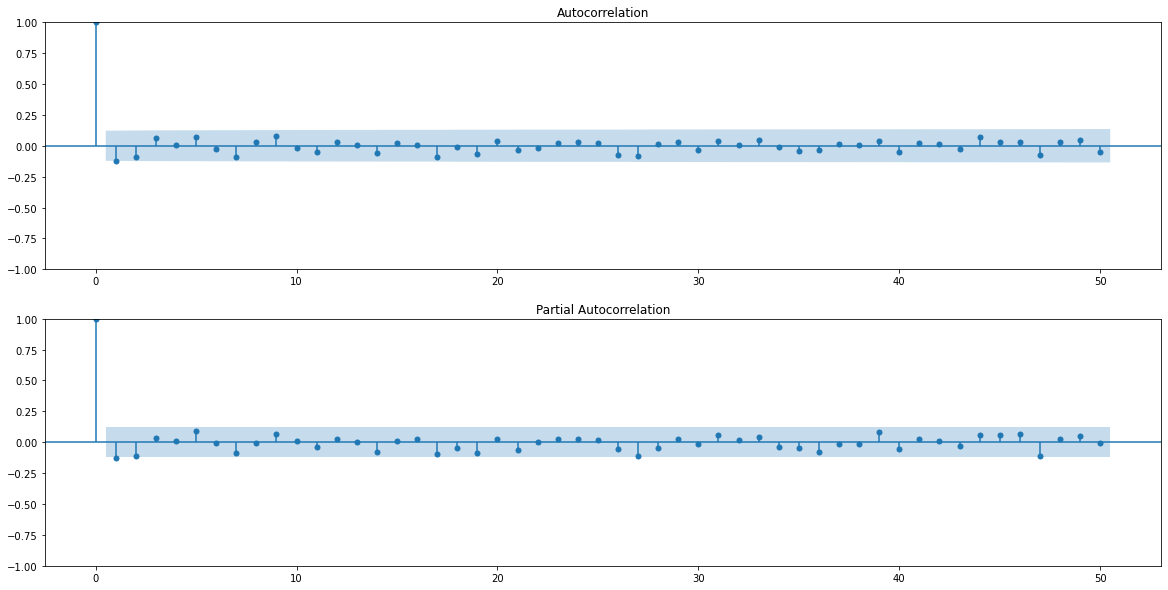

In [8]:
#ACF-PACF

fig, ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df['close_MSFT'].diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df['close_MSFT'].diff().dropna(), lags=50, ax=ax[1])
plt.show()


#PLOT INDICATES NO LAG SPIKES BETWEEN ACF AND PACF, indicating the differencing is enough without the needs of AR or MA

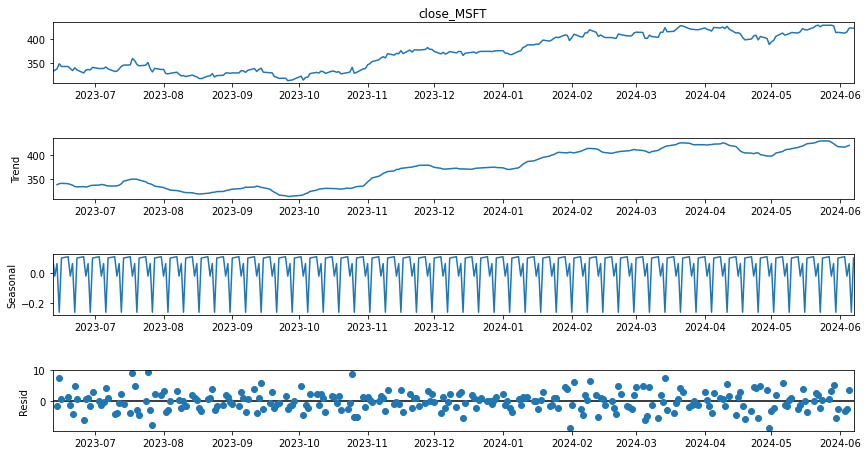

In [9]:
import statsmodels.api as sm

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(df['close_MSFT'], model='additive')
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()


In [10]:
import warnings
warnings.filterwarnings("ignore")
model = SARIMAX(df['close_MSFT'],order=(0,1,0), seasonal_order=(1, 1, 1, 5),exog=df[['close_AAPL','close_AMZN','close_GOOGL']])

In [11]:
res = model.fit(disp=False)

In [12]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          close_MSFT   No. Observations:                  260
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 5)   Log Likelihood                -689.053
Date:                             Wed, 12 Jun 2024   AIC                           1390.106
Time:                                     11:27:27   BIC                           1411.330
Sample:                                 06-12-2023   HQIC                          1398.645
                                      - 06-07-2024                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
close_AAPL      0.5255      0.103      5.079      0.000       0.323       0.728
close_AMZN      0.8649      0.101      8.522      0.000       0.666       1.064
close_GOOGL     0.2448      0.080      3.061      0.002       0.088       0.402
ar.S.L5         0.1206      0.085      1.423      0.155      -0.046       0.287
ma.S.L5        -0.9994      2.738     -0.365      0.715      -6.365       4.366
sigma2         12.3702     33.442      0.370      0.711     -53.174      77.914
===================================================================================
Ljung-Box (L1) (Q):                   5.06   Jarque-Bera (JB):               299.70
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.58
Prob(H) (two-sided):                  0.89   Kurtosis:                         8.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
# Check the length of the DataFrame
total_length = len(df)
print(f"Total length of DataFrame: {total_length}")

# # Display the first and last few indices to understand the range
# print("First few indices:", df.index[:5])
# print("Last few indices:", df.index[-5:])

# Determine a valid range for forecasting
# Ensure that the range is within the bounds of the DataFrame
valid_start = total_length - 5  # Example: Start 66 periods before the end
valid_end = total_length - 1     # Example: End at the last index




# Check the length of the exog DataFrame for the valid forecast period
exog_forecast = df[['close_AAPL', 'close_AMZN', 'close_GOOGL']].iloc[valid_start:valid_end+1]


Total length of DataFrame: 260


In [14]:
# Out-of-sample forecast using forecast
forecast_steps = 5
forecast_values =  res.forecast(steps=forecast_steps, exog=exog_forecast)

df_forecast = pd.DataFrame(forecast_values)

In [15]:
df_forecast

,predicted_mean
2024-06-10,416.082395
2024-06-11,417.957063
2024-06-12,422.025908
2024-06-13,424.375033
2024-06-14,424.129909


In [16]:
df = pd.concat([df,df_forecast],axis=1)

In [17]:
df

,close_AAPL,close_AMZN,close_GOOGL,close_MSFT,predicted_mean
2023-06-12,183.789993,126.570000,123.639999,331.850006,NaN
2023-06-13,183.309998,126.660004,123.830002,334.290009,NaN
2023-06-14,183.949997,126.419998,123.669998,337.339996,NaN
2023-06-15,186.009995,127.110001,125.089996,348.100006,NaN
2023-06-16,184.919998,125.489998,123.529999,342.329987,NaN
...,...,...,...,...,...
2024-06-10,NaN,NaN,NaN,NaN,416.082395
2024-06-11,NaN,NaN,NaN,NaN,417.957063
2024-06-12,NaN,NaN,NaN,NaN,422.025908
2024-06-13,NaN,NaN,NaN,NaN,424.375033


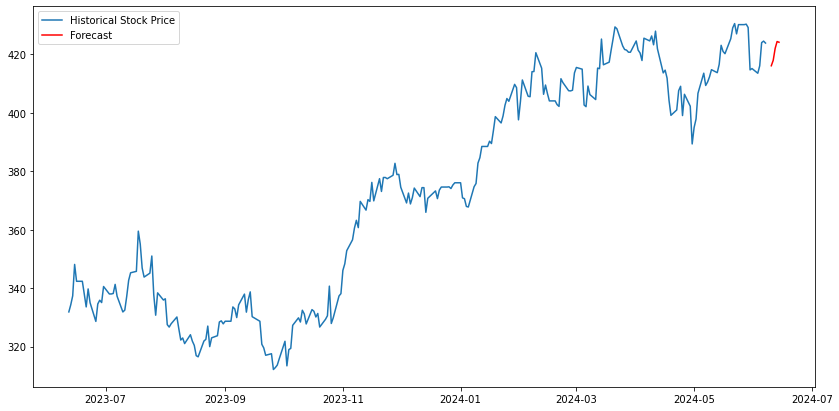

In [18]:
# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df['close_MSFT'], label='Historical Stock Price')
plt.plot(df['predicted_mean'], label='Forecast', color='red')
plt.legend()
plt.show()

In [19]:
joblib.dump(res, 'sarimax_model.pkl')
print("Model saved successfully")

Model saved successfully


# MANUAL INSERTION

In [21]:
# MySQL database details
host = 'mysql-tartilaportfolio-mtartila-project-portfolio.g.aivencloud.com'
database = 'defaultdb'
user = 'avnadmin'
password = 'AVNS_xCxZRTAn3zfvRAwFs1E'
port = 13624  # Custom port for Aiven MySQL

In [25]:
inserted_date = datetime.datetime.now()

In [28]:
try:
    connection = pymysql.connect(
        host=host,
        user=user,
        password=password,
        database=database,
        port=port
    )

    cursor = connection.cursor()

    # Create table if it doesn't exist
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS finnhub_stock_data_daily (
        symbol VARCHAR(10),
        record_date DATE,
        daily_avg_open FLOAT,
        daily_avg_high FLOAT,
        daily_avg_low FLOAT,
        daily_avg_close FLOAT,
        sarimax_prediction FLOAT,
        transformed_date DATETIME,
        PRIMARY KEY (symbol, record_date)
    )
    """)

    # Insert SARIMAX predictions
    for record_date, row in df_forecast.iterrows():
        cursor.execute("""
            INSERT INTO finnhub_stock_data_daily (symbol, record_date, sarimax_prediction, transformed_date)
            VALUES (%s, %s, %s, %s)
            ON DUPLICATE KEY UPDATE
                sarimax_prediction = VALUES(sarimax_prediction),
                transformed_date = VALUES(transformed_date)
        """, ('MSFT', record_date.date(), row['predicted_mean'], inserted_date))

    connection.commit()
    print("SARIMAX predictions inserted successfully")
            
except pymysql.MySQLError as e:
    print(f"Error: {e}")
finally:
    if connection:
        cursor.close()
        connection.close()
        print("MySQL connection is closed")

SARIMAX predictions inserted successfully
MySQL connection is closed
